# A Simple TF 2.2 notebook

This is intended as a simple, short introduction to the operations competitors will need to perform with TPUs.

In [3]:
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import numpy as np
#from tensorflow.keras.applications import DenseNet201

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


# Detect my accelerator

In [4]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2022-05-13 05:34:15.671240: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-05-13 05:34:15.671303: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30042}
2022-05-13 05:34:15.676924: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-05-13 05:34:15.677082: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30042}


REPLICAS:  8


# Get my data path

In [5]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path() # you can list the bucket with "!gsutil ls $GCS_DS_PATH"

# Set some parameters

In [6]:
IMAGE_SIZE = [192, 192] # at this size, a GPU will run out of memory. Use the TPU
EPOCHS = 10
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

NUM_TRAINING_IMAGES = 12753
NUM_TEST_IMAGES = 7382
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

# Load my data

This data is loaded from Kaggle and automatically sharded to maximize parallelization.

In [7]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset():
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-192x192/train/*.tfrec'), labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-192x192/val/*.tfrec'), labeled=True, ordered=False)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-192x192/test/*.tfrec'), labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()

2022-05-13 05:34:32.057735: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-05-13 05:34:32.305263: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [8]:
SEED = 2020

def random_blockout(img, sl=0.1, sh=0.2, rl=0.4):
    p=random.random()
    if p>=0.25:
        w, h, c = IMAGE_SIZE[0], IMAGE_SIZE[1], 3
        origin_area = tf.cast(h*w, tf.float32)

        e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * rl)), tf.int32)
        e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh / rl)), tf.int32)

        e_height_h = tf.minimum(e_size_h, h)
        e_width_h = tf.minimum(e_size_h, w)

        erase_height = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tf.int32)
        erase_width = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tf.int32)

        erase_area = tf.zeros(shape=[erase_height, erase_width, c])
        erase_area = tf.cast(erase_area, tf.uint8)

        pad_h = h - erase_height
        pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
        pad_bottom = pad_h - pad_top

        pad_w = w - erase_width
        pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
        pad_right = pad_w - pad_left

        erase_mask = tf.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
        erase_mask = tf.squeeze(erase_mask, axis=0)
        erased_img = tf.multiply(tf.cast(img,tf.float32), tf.cast(erase_mask, tf.float32))

        return tf.cast(erased_img, img.dtype)
    else:
        return tf.cast(img, img.dtype)

    
def data_augment_v2(image, label):
    # Thanks to the dataset.prefetch(AUTO) statement in the next function (below), this happens essentially for free on TPU. 
    # Data pipeline code is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.
    
    flag = random.randint(1,3)
    coef_1 = random.randint(70, 90) * 0.01
    coef_2 = random.randint(70, 90) * 0.01
    
    if flag == 1:
        image = tf.image.random_flip_left_right(image, seed=SEED)
    elif flag == 2:
        image = tf.image.random_flip_up_down(image, seed=SEED)
    else:
        image = tf.image.random_crop(image, [int(IMAGE_SIZE[0]*coef_1), int(IMAGE_SIZE[0]*coef_2), 3],seed=SEED)
        
    image = random_blockout(image)
    
    return image, label 

In [9]:
import tensorflow_addons as tfa

# Randomly make some changes to the images and return the new images and labels
def data_augment_v3(image, label):
        
    # Set seed for data augmentation
    seed = 100
    
    # Randomly resize and then crop images
    image = tf.image.resize(image, [720, 720])
    image = tf.image.random_crop(image, [512, 512, 3], seed = seed)

    # Randomly reset brightness of images
    image = tf.image.random_brightness(image, 0.6, seed = seed)
    
    # Randomly reset saturation of images
    image = tf.image.random_saturation(image, 3, 5, seed = seed)
        
    # Randomly reset contrast of images
    image = tf.image.random_contrast(image, 0.3, 0.5, seed = seed)

    # Randomly reset hue of images, but this will make the colors really weird, which we think will not happen
    # in common photography
    # image = tf.image.random_hue(image, 0.5, seed = seed)
    
    # Blur images
    image = tfa.image.mean_filter2d(image, filter_shape = 10)
    
    # Randomly flip images
    image = tf.image.random_flip_left_right(image, seed = seed)
    image = tf.image.random_flip_up_down(image, seed = seed)
    
    # Fail to rotate and transform images due to some bug in TensorFlow
    # angle = random.randint(0, 180)
    # image = tfa.image.rotate(image, tf.constant(np.pi * angle / 180))
    # image = tfa.image.transform(image, [1.0, 1.0, -250, 0.0, 1.0, 0.0, 0.0, 0.0])
    
    return image, label

In [10]:
strategy.num_replicas_in_sync

8

In [11]:
16 * strategy.num_replicas_in_sync

128

In [12]:
# Define the batch size. This will be 16 with TPU off and 128 (=16*8) with TPU on
BATCH_SIZE = 16 * strategy.num_replicas_in_sync #See Note 3.1 above 😀

ds_train = training_dataset
ds_valid = validation_dataset
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

Training: <BatchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>
Validation: <CacheDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>
Test: <BatchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.string)>


2022-05-13 05:34:48.890150: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [13]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape) #See Note 3.1 above 😀
print("Training data label examples:", label.numpy())

Training data shapes:
(128, 192, 192, 3) (128,)
(128, 192, 192, 3) (128,)
(128, 192, 192, 3) (128,)
Training data label examples: [103  73  59 ...  14  72  18]


2022-05-13 05:34:57.973971: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 58, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1652420097.970604255","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 58, Output num: 1","grpc_status":3}


In [14]:
print("Test data shapes:")
for image, idnum in ds_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape) #See Note 3.1 above 😀
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Test data shapes:
(128, 192, 192, 3) (128,)
(128, 192, 192, 3) (128,)
(128, 192, 192, 3) (128,)
Test data IDs: ['b87e16bc0' 'd8437a7f7' '981396649' ... '15cb0c24a' '1c3a7bc99' 'b20b97998']


In [15]:
from matplotlib import pyplot as plt

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
        # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 
                                'OK' if correct else 'NO', 
                                u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None, display_mismatches_only=False):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        if display_mismatches_only:
            if predictions[i] != label:
                subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
        else:        
            subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

def display_training_curves_v2(training, validation, learning_rate_list, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title, color='b')
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.', 'learning rate'])        
    
    ax2 = ax.twinx()
    ax2.plot(learning_rate_list, 'g-')
    ax2.set_ylabel('learning rate', color='g')

In [16]:
print("Test data shapes:")
for image, idnum in ds_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape) #See Note 3.1 above 😀
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Test data shapes:
(128, 192, 192, 3) (128,)
(128, 192, 192, 3) (128,)
(128, 192, 192, 3) (128,)
Test data IDs: ['b87e16bc0' 'd8437a7f7' '981396649' ... '15cb0c24a' '1c3a7bc99' 'b20b97998']


2022-05-13 05:36:03.663043: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 98, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1652420163.662943169","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 98, Output num: 1","grpc_status":3}


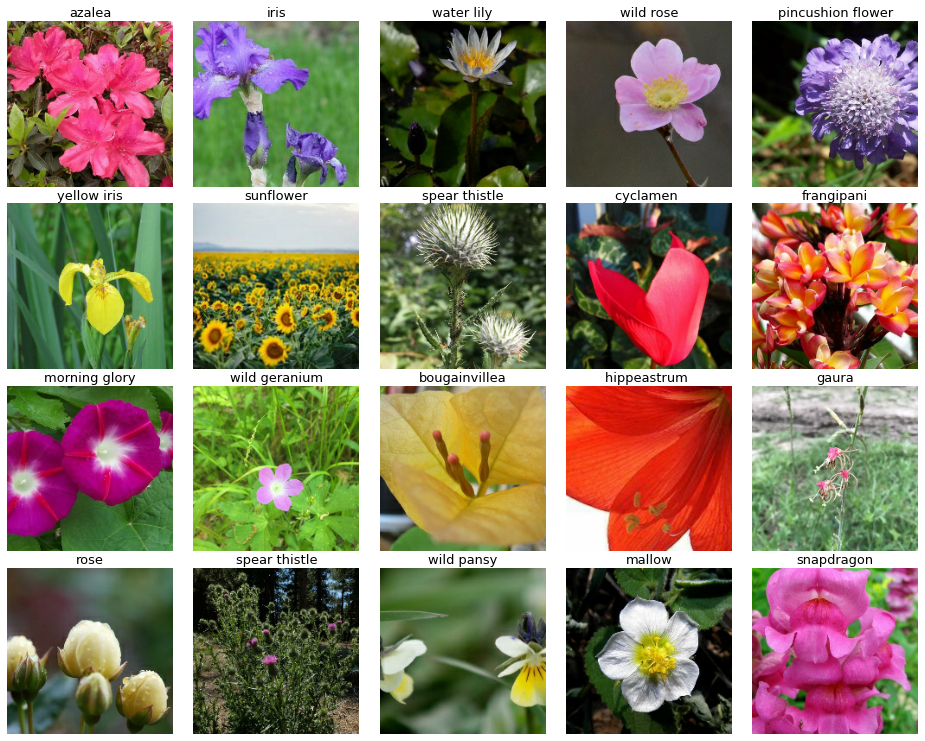

In [20]:
import math
ds_iter = iter(ds_train.unbatch().batch(20))

one_batch = next(ds_iter)
display_batch_of_images(one_batch)

In [21]:
def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO) statement in the next function (below), this happens essentially for free on TPU. 
    # Data pipeline code is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

2022-05-13 05:40:40.089932: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


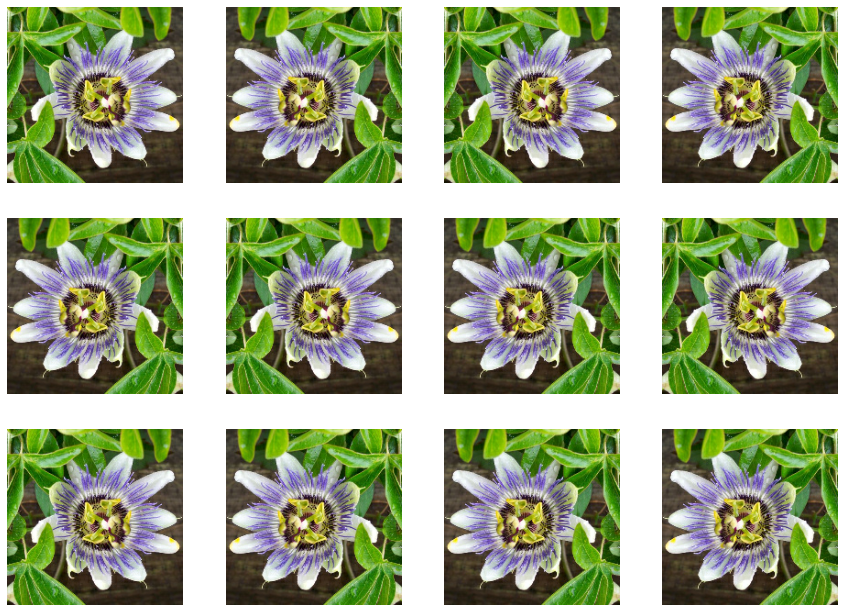

In [22]:
row = 3
col = 4
all_elements = get_training_dataset().unbatch()
one_element = tf.data.Dataset.from_tensors(next(iter(all_elements)))
# Map the images to the data augmentation function for image processing
augmented_element = one_element.repeat().map(data_augment).batch(row * col)

for (img, label) in augmented_element:
    plt.figure(figsize = (15, int(15 * row / col)))
    for j in range(row * col):
        plt.subplot(row, col, j + 1)
        plt.axis('off')
        plt.imshow(img[j, ])
    plt.show()
    break

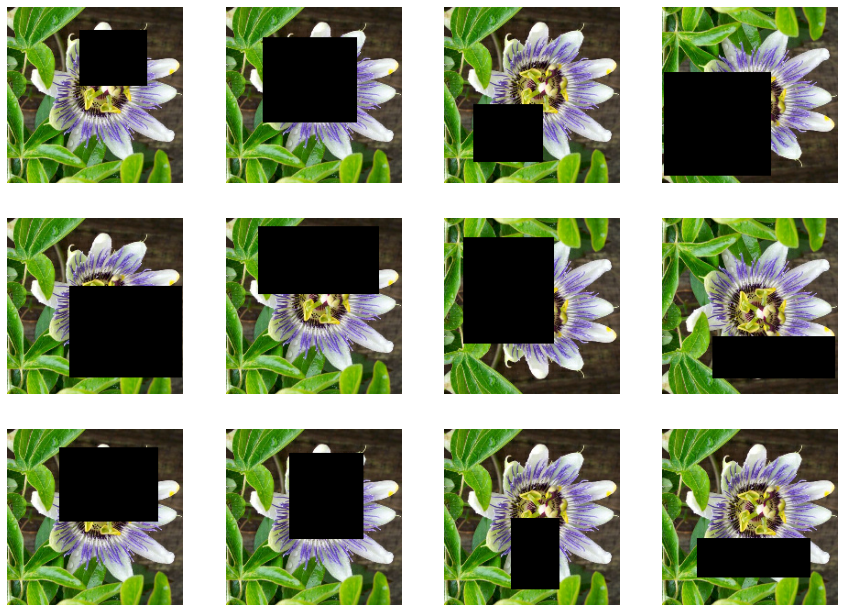

In [23]:
import random
augmented_element = one_element.repeat().map(data_augment_v2).batch(row * col)

for (img, label) in augmented_element:
    plt.figure(figsize = (15, int(15 * row / col)))
    for j in range(row * col):
        plt.subplot(row, col, j + 1)
        plt.axis('off')
        plt.imshow(img[j, ])
    plt.show()
    break

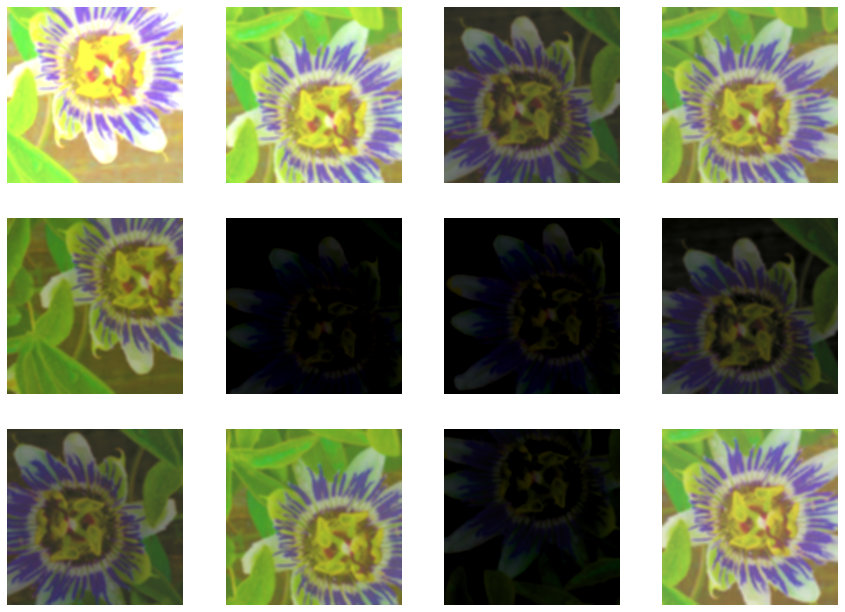

In [24]:
augmented_element = one_element.repeat().map(data_augment_v3).batch(row * col)

for (img, label) in augmented_element:
    plt.figure(figsize = (15, int(15 * row / col)))
    for j in range(row * col):
        plt.subplot(row, col, j + 1)
        plt.axis('off')
        plt.imshow(img[j, ])
    plt.show()
    break

In [25]:
[*IMAGE_SIZE, 3]

[192, 192, 3]

In [31]:
'''data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape= [*IMAGE_SIZE, 3]),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)'''

# Build a model on TPU (or GPU, or CPU...) with Tensorflow 2.1!

In [36]:
with strategy.scope():    
    pretrained_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    pretrained_model.trainable = False # tramsfer learning
    
    model = tf.keras.Sequential([
        pretrained_model,  
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(104, activation='softmax')
    ])
        
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

historical = model.fit(training_dataset,
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=30, 
          validation_data=validation_dataset)

Epoch 1/30
99/99 [==============================] - 43s 231ms/step - loss: 3.2722 - sparse_categorical_accuracy: 0.2852 - val_loss: 1.6852 - val_sparse_categorical_accuracy: 0.5773
Epoch 2/30
 3/99 [..............................] - ETA: 3s - loss: 1.4595 - sparse_categorical_accuracy: 0.6645

2022-05-13 06:24:43.439584: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 389562, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1652423083.439496053","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 389562, Output num: 1","grpc_status":3}


99/99 [==============================] - 12s 126ms/step - loss: 1.3978 - sparse_categorical_accuracy: 0.6475 - val_loss: 1.4147 - val_sparse_categorical_accuracy: 0.6406
Epoch 3/30
99/99 [==============================] - 12s 125ms/step - loss: 1.0683 - sparse_categorical_accuracy: 0.7153 - val_loss: 1.3029 - val_sparse_categorical_accuracy: 0.6708
Epoch 4/30
99/99 [==============================] - 12s 126ms/step - loss: 0.8512 - sparse_categorical_accuracy: 0.7764 - val_loss: 1.2257 - val_sparse_categorical_accuracy: 0.6802
Epoch 5/30
99/99 [==============================] - 12s 125ms/step - loss: 0.7192 - sparse_categorical_accuracy: 0.8145 - val_loss: 1.1743 - val_sparse_categorical_accuracy: 0.7004
Epoch 6/30
99/99 [==============================] - 12s 126ms/step - loss: 0.6245 - sparse_categorical_accuracy: 0.8401 - val_loss: 1.1731 - val_sparse_categorical_accuracy: 0.6977
Epoch 7/30
99/99 [==============================] - 12s 125ms/step - loss: 0.5430 - sparse_categorical_acc

# Compute your predictions on the test set!

This will create a file that can be submitted to the competition.

In [37]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

2022-05-13 06:31:18.787695: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Computing predictions...


2022-05-13 06:31:48.786372: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 422220, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1652423508.786234480","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 422220, Output num: 0","grpc_status":3}


[67 41 81 ... 14 40 79]
Generating submission.csv file...


In [ ]:
'''with strategy.scope():    
    pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    pretrained_model.trainable = True # tramsfer learning
    
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.Conv2D(64, kernel_size = 3, kernel_initializer='he_normal', strides=1, activation='relu',padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
        tf.keras.layers.Conv2D(64, kernel_size = 3,kernel_initializer='he_normal', activation='relu',padding='same'),
        
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(104, activation='softmax')
    ])
        
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

historical = model.fit(training_dataset, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=EPOCHS, 
          validation_data=validation_dataset)'''

2022-05-13 05:37:55.606912: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 151, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1652420275.606751114","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 151, Output num: 1","grpc_status":3}


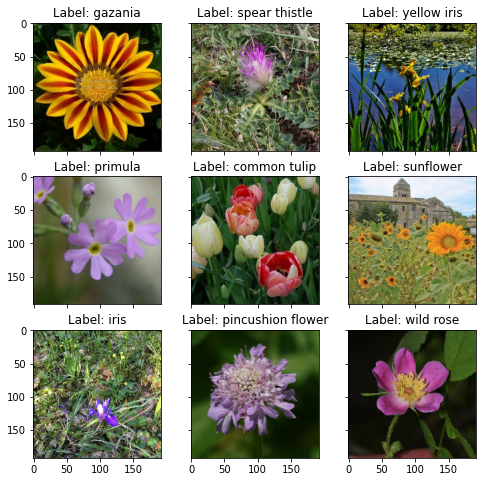

In [19]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']



fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(8,8))

index = 0
for i in range(3):
    for j in range(3):
        sample = training_dataset
        for img, label in training_dataset.take(1):
            axs[i, j].imshow(img[index])
            axs[i, j].set_title(f"Label: {CLASSES[label[index]]}")
        index += 1
plt.show()

In [ ]:
training_dataset.shape